<a href="https://colab.research.google.com/github/vss245/nma_code/blob/master/hcp_fmri_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro and theory
Dataset: HCP fMRI dataset, preprocessed and parcellated into 360 ROIs

Task: Observing shapes moving either randomly or appearing to interact "socially"
 
Question: how does the brain encode viewing social interaction?

ROIs: temporoparietal junction, superior temporal sulcus, medial prefrontal cortex, fusiform gyrus, occipital gyrus, amygdala, insula 

Model: 
- ROIs indicated above interact with each other throughout this process of observing social interaction
- We can measure this interaction via effective connectivity (e.g. Granger causality)
- Viewing social interaction will increase GC between the ROIs, whereas random motion will not (control: random network, such as lower visual areas) 

Approach:
- extract time series for every subject for these ROIs in both conditions
- calculate GC between them (multivariate GC? fit a VAR?)

Hypothesis: viewing social interaction increases connectivity between areas within the "social network" of the brain

Statistics: 
- due to the structure of the experiment, we obtain GC separately for each condition per run and average across runs
- after that, we have 1 GC value per condition per pairs of regions per subject (potentially we can subtract the two GC values and just look at the GC condition difference per pairs of regions per subject)
- group level stats: ANOVA 


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters

In [2]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Loading functions

In [3]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [4]:
#@title Helper functions: get image index, load_timeseries, load_evs (provided)
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averaged across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

## Region info

In [78]:
# get region info from data
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

regionsdf = pd.DataFrame.from_dict(region_info)
# make a dictionary with all of the above, figure out details later - mPFC?
roi_names = ['STS', 'TPOJ', 'ACC_mPFC', 'fusiform', 'insula']
roi_codes = [['STSdp', 'STSda', 'STSvp', 'STSva'],
            ['TPOJ1',  'TPOJ2',  'TPOJ3'],
             #'33pr' (coordinating emotion),  'p24pr' (stimulus and response selection during cognitively demanding tasks),  'a24pr',  'p24',  'a24' - ACC (may not be relevant to the task)
             #'p32pr' (SFG, stimulus response selection), 
             #'s32 (higher order role in emotional affect as well as reward expectation)
             # 8BM (coordinating visuospatial information)
             # '9m' increased activity when monitoring multiple pieces of spatialinformation
             #10 r (importance in concentration and working memory)
            ['a32pr',  'd32' 'p32', '10v',  '10r', '25'],
            ['FFC'],  
            ['Ig']]

# loop over all subregions within a region, get the indices, combine

def load_subject_rois(subject,run):
  '''
  Takes:
    subject index
    run index
  Returns:
    region x timeseries
  Load all ROI timeseries for each subject and run 
  Average between all the subregions => 1 ROI time series
  '''

  ts = np.squeeze(load_timeseries(subject,'SOCIAL',runs=run,concat=False))
  ts_all_rois = []
  roi_indexes = []
  for r in range(len(roi_names)):
    subreg_indexes = []
    for sr in roi_codes[r]:
      index_list = regionsdf.index[regionsdf['name'].str.contains(sr)].tolist()
      subreg_indexes = subreg_indexes + index_list
    roi_indexes.append(subreg_indexes)

  for r in range(len(roi_names)):
    ts_roi = np.mean(ts[roi_indexes[r],],0)
    ts_all_rois.append(ts_roi)
  return ts_all_rois

#by Ruben
def get_ts_condition(ts,subject,task,run,condition):
  """
  Loads HCP timeseries data for the specified subject and run and condition.

  INPUTS:
    ts: timeseries (Nregions x Ntimepoints)
    subject: subject number
    task: task name
    run: run number
    condition: condition name

  OUTPUT:
    timeseries of condition for the subject and run, divided by blocks.
    Returns a Nregions x Nblocks x time array.
  
  """

  # Load block onsets
  evs = load_evs(subject,task,condition)

  # Get all frames for condition in run
  frames = condition_frames(evs)
  frames = frames[run]

  # Separate frames by blocks (split where frames numbers increase > 1)
  frames = np.split(frames, np.where(np.diff(frames)>1)[0] + 1)

  # Initialize output array of shape Nregions x Nblocks x Ntime_frames_per_block
  ts_condition = np.zeros((np.shape(ts)[0],np.shape(frames)[0],np.shape(frames)[1]))

  # Fill per block and region
  for block in range(np.shape(frames)[0]):
    for region in range(np.shape(ts)[0]):
      ts_condition[region,block,:] = ts[region][frames[block]]
  
  return ts_condition

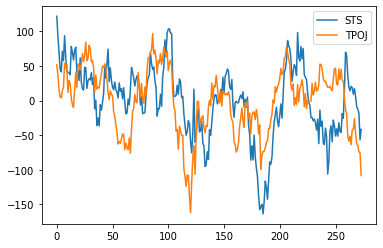

In [79]:
subject_data = load_subject_rois(0,0)
# Pick a random region to compare - V1
region1 = subject_data[0]
region2 = subject_data[1]
plt.plot(region1,label=roi_names[0]) 
plt.plot(region2,label=roi_names[1]) 
plt.legend()

In [ ]:
https://github.com/ansteeg/NeuroMatchProject/blob/master/atlas/hcp_parcels.csv

# Granger causality

In [8]:
!pip install nitime
import nitime
import nitime.analysis as nta
import nitime.timeseries as ts
import nitime.utils as tsu

     |████████████████████████████████| 9.1MB 2.6MB/s 
  Created wheel for nitime: filename=nitime-0.8.1-cp36-cp36m-linux_x86_64.whl size=4038228 sha256=24dffe20cc5f164f107aa776c61e2f352d86ed462524ad8d450d9ad15916d5ef
  Stored in directory: /root/.cache/pip/wheels/74/02/c5/677c895b41dcaf4fd7c4ff436fbdf8a5d846ed90a0a3276073
Successfully built nitime


In [80]:
# Functions from Ruben 

def calculate_granger_causality(ts,TR,f_ub=0.15,f_lb=0.02,order=None,max_order=10):
  """
  Calculates Granger Causality in timeseries between all regions in both
  directions, then calculates the difference between the two. Thus, a positive 
  value indicates stronger causality for region X on region Y, negative values
  vice versa.

  INPUT:
    ts: time series (Nregions x Ntimepoints)
    TR: repetition time of scanner during fMRI data acquisition
    f_ub: "physiologically relevant" frequency upper bound (Default: 0.15)
    f_lb: "physiologically relevant" frequency lower bound (Default: 0.02)
    order: order of autoregressive model. Default is None, in which case the 
           order is determined automatically (max is max_order).
    max_order: maximum order of autoregressive model (Default: 10)

  OUTPUT:
    returns 
  """

  # Normalize the data in each of the ROIs to be in units of % change 
  pdata = tsu.percent_change(ts)

  # Initialize the TimeSeries object:
  time_series = ts.TimeSeries(pdata, sampling_interval=TR)

  # Initialize the GrangerAnalyzer object
  G = nta.GrangerAnalyzer(time_series,order=order,max_order=max_order)

  # We are only interested in the physiologically relevant frequency band 
  # (specified upper and lower bounds in f_ub and f_lb). Keep only the 
  # frequencies within that band
  freq_idx_G = np.where((G.frequencies > f_lb) * (G.frequencies < f_ub))[0]

  # Take the difference of causality in direction XY versus direction YX
  GCdiff = np.mean(G.causality_xy[:, :, freq_idx_G] - G.causality_yx[:, :, freq_idx_G], -1)

  return GCdiff

In [90]:
# define things
subject = 0
run = 0
task = 'SOCIAL'
condition = 'mental'
# Get data for a particular condition for a subject
ts = load_subject_rois(subject,run)
subject_info = get_ts_condition(ts,subject,task,run,condition)

In [82]:
TR = 0.72 # time res
f_ub = 0.15
f_lb = 0.02 # physiologically relevant freqs

In [92]:
g_caus = calculate_granger_causality(ts, TR, f_ub, f_lb)

AttributeError: ignored

In [14]:
plt.imshow(g_caus)

NameError: ignored

# ANOVA

In [32]:
# easy way to access the resulting matrix of GC values for all the regions
from itertools import combinations 
#key - pair of region names
#value - indices in GCdiff
pairs = list(combinations([0,1,2,3,4], 2))
region_pairs_GC = {}
for i in range(len(pairs)):
  key = roi_names[pairs[i][0]] + '_' + roi_names[pairs[i][1]]
  region_pairs_GC[key] = pairs[i]
print(region_pairs_GC)

{'STS_TPOJ': (0, 1), 'STS_ACC_mPFC': (0, 2), 'STS_fusiform': (0, 3), 'STS_insula': (0, 4), 'TPOJ_ACC_mPFC': (1, 2), 'TPOJ_fusiform': (1, 3), 'TPOJ_insula': (1, 4), 'ACC_mPFC_fusiform': (2, 3), 'ACC_mPFC_insula': (2, 4), 'fusiform_insula': (3, 4)}


In [95]:
# result - 4 columns (subject, region pair, condition, GC diff)
subjects = range(0,101)
conditions = ['mental','random']
columns = ['subject','region_pair', 'condition', 'gc_diff']
df = pd.DataFrame(columns=columns)
for subject in subjects:
  for condition in conditions:
    for rp in region_pairs_GC:
      df = df.append({
     "subject": subject,
     "region_pair":  rp,
     "condition": condition,
     "gc_diff": np.random.random()
      }, ignore_index=True)
df

,subject,region_pair,condition,gc_diff
0,0,STS_TPOJ,mental,0.822908
1,0,STS_ACC_mPFC,mental,0.394290
2,0,STS_fusiform,mental,0.478723
3,0,STS_insula,mental,0.248066
4,0,TPOJ_ACC_mPFC,mental,0.211449
...,...,...,...,...
2015,100,TPOJ_fusiform,random,0.013215
2016,100,TPOJ_insula,random,0.280980
2017,100,ACC_mPFC_fusiform,random,0.379865
2018,100,ACC_mPFC_insula,random,0.607866


In [100]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
mod = ols('gc_diff ~ condition*region_pair', data=df).fit()
aov_table = sm.stats.anova_lm(mod, typ=3)
print(aov_table)

                           sum_sq      df           F        PR(>F)
Intercept               22.151760     1.0  277.271653  2.100052e-58
condition                0.025375     1.0    0.317621  5.731039e-01
region_pair              0.755262     9.0    1.050394  3.970087e-01
condition:region_pair    0.640704     9.0    0.891070  5.323743e-01
Residual               159.783808  2000.0         NaN           NaN
